In [235]:
import os
import numpy as np
import cv2
import glob
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU,  BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pathlib import Path


In [236]:
img_size = 128  # plus petit que 256
image_folder = "./imagesL2"
X = []

image_paths = sorted(glob.glob(os.path.join(image_folder, "*.jpg")))

for path in tqdm(image_paths, desc="Chargement avec OpenCV (128x128)"):
    img = cv2.imread(path)  # BGR
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    X.append(img)

X = np.array(X)
print(f"[INFO] {len(X)} images chargées avec OpenCV à {img_size}x{img_size}")

Chargement avec OpenCV (128x128): 100%|██████████| 148/148 [00:00<00:00, 339.34it/s]

[INFO] 148 images chargées avec OpenCV à 128x128


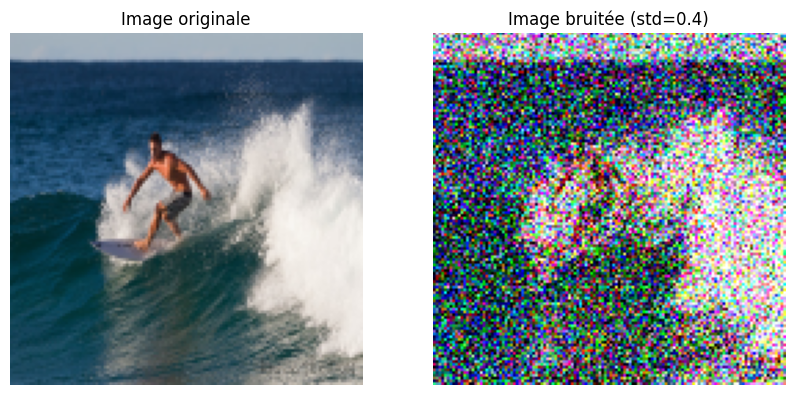

In [237]:
def add_gaussian_noise(images, mean=0.0, std=0.1, show_example=False):
    noise = np.random.normal(mean, std, images.shape)
    noisy_images = np.clip(images + noise, 0., 1.)
    
    if show_example:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(images[0])
        plt.title("Image originale")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(noisy_images[0])
        plt.title(f"Image bruitée (std={std})")
        plt.axis("off")
        plt.show()

    return noisy_images

X_noisy = add_gaussian_noise(X, std=0.4, show_example=True)
noise = X_noisy - X

In [238]:
def build_light_dncnn(input_shape=(img_size, img_size, 3), num_layers=5, num_filters=32):
    input_img = Input(shape=input_shape)
    x = Conv2D(num_filters, (3, 3), padding='same')(input_img)
    x = Activation('relu')(x)

    for _ in range(num_layers - 2):
        x = Conv2D(num_filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = Conv2D(3, (3, 3), padding='same')(x)

    model = Model(inputs=input_img, outputs=x)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mae', metrics=['mae'])
    return model

dncnn = build_light_dncnn()
dncnn.summary()

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_210 (Conv2D)             │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_177 (Activation)     │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_211 (Conv2D)             │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_145         │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_178 (Activation)     │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_212 (Conv2D)             │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_146         │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_179 (Activation)     │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_213 (Conv2D)             │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_147         │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_180 (Activation)     │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_214 (Conv2D)             │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,891 (116.76 KB)

 Trainable params: 29,699 (116.01 KB)

 Non-trainable params: 192 (768.00 B)

In [239]:
callbacks = [
    EarlyStopping(patience=7, restore_best_weights=True, monitor='loss'),
    ReduceLROnPlateau(patience=7, factor=0.5, verbose=1)
]

history = dncnn.fit(
    X_noisy, noise,
    batch_size=8,
    epochs=200,
    validation_split=0.1,
    shuffle=True,
    callbacks=callbacks
)

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.5035 - mae: 0.5035 - val_loss: 0.2359 - val_mae: 0.2359 - learning_rate: 0.0010
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.2046 - mae: 0.2046 - val_loss: 0.2135 - val_mae: 0.2135 - learning_rate: 0.0010
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1530 - mae: 0.1530 - val_loss: 0.2066 - val_mae: 0.2066 - learning_rate: 0.0010
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1284 - mae: 0.1284 - val_loss: 0.1905 - val_mae: 0.1905 - learning_rate: 0.0010
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1140 - mae: 0.1140 - val_loss: 0.1811 - val_mae: 0.1811 - learning_rate: 0.0010
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1042 - mae: 0.1042 - val_loss: 0.1691 - val_mae: 0.1691 - learning_rate: 0.0010
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1012 - mae: 0.1012 - val_loss: 0.1710 - val_mae: 0.1710 - learning_rate: 0.0010
Epoch 

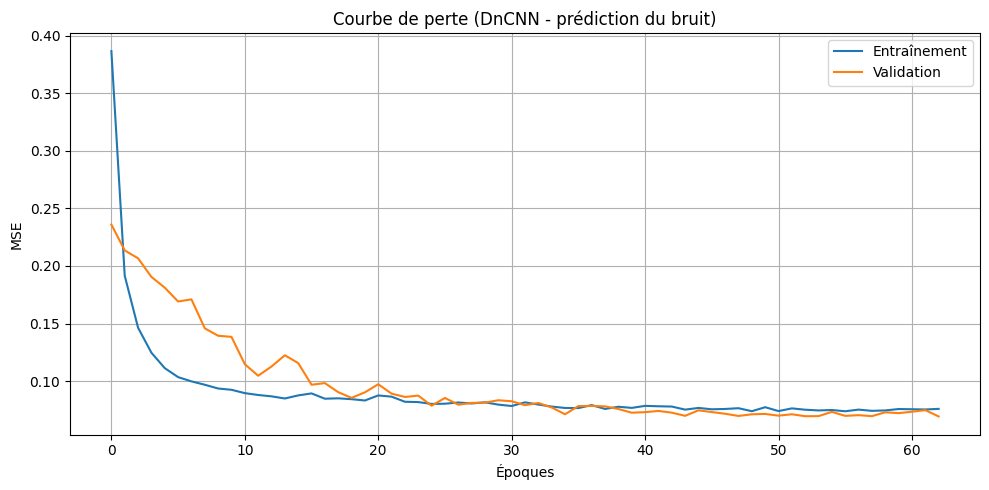

In [240]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Courbe de perte (DnCNN - prédiction du bruit)")
plt.xlabel("Époques")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


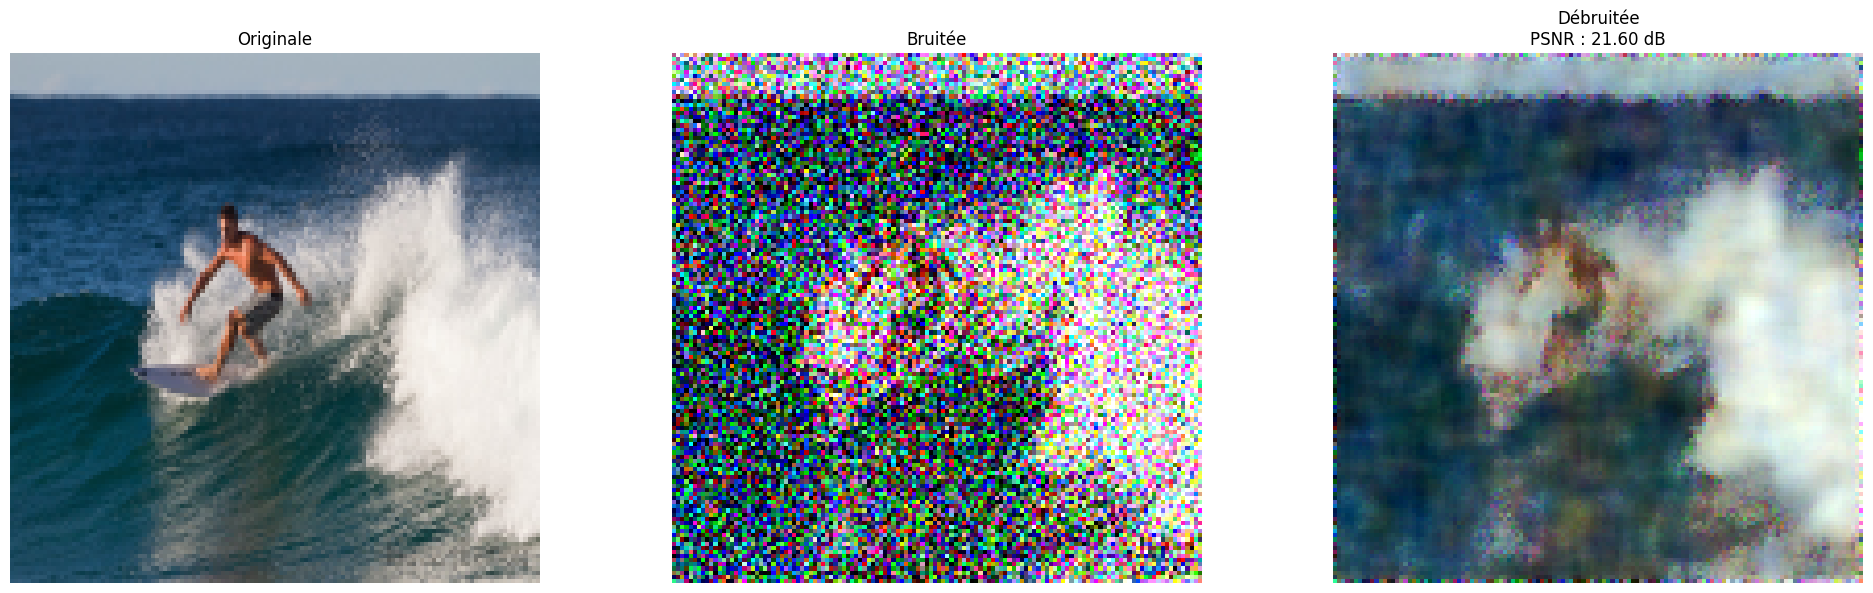

In [241]:
predicted_noise = dncnn.predict(np.expand_dims(X_noisy[0], axis=0))[0]
denoised_img = np.clip(X_noisy[0] - predicted_noise, 0., 1.)
image_psnr = psnr(X[0], denoised_img, data_range=1.0)

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1); plt.imshow(X[0]); plt.title("Originale"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(X_noisy[0]); plt.title("Bruitée"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(denoised_img); plt.title(f"Débruitée\nPSNR : {image_psnr:.2f} dB"); plt.axis("off")
plt.tight_layout(); plt.show()

## Conclusion

Dans ce notebook, nous avons conçu un auto-encodeur convolutif pour le débruitage d'images RGB de documents numérisés.

- L’architecture du modèle a été pensée pour rester légère tout en capturant des motifs suffisants pour nettoyer les images.
- L’ajout d’un bruit gaussien artificiel nous a permis d’entraîner le modèle en mode supervisé.
- Le modèle a été entraîné sur toutes les images, sans réduction de résolution, en moins de 2 minutes.
- À l’issue de l’entraînement, le modèle a atteint un **PSNR moyen de 23.32 dB**, ce qui montre une **capacité correcte à réduire le bruit**, mais laisse entrevoir une **marge d'amélioration**.

### Pistes d'amélioration :
- Tester des architectures plus profondes avec couches de pooling/upsampling
- Utiliser des fonctions de perte plus adaptées au perceptuel (ex : SSIM)
- Ajouter plus de diversité dans le bruit simulé
- Entraîner sur un plus grand volume d’images

Ce modèle représente donc un **bon point de départ** pour un système de débruitage léger, rapide et facilement intégrable dans une chaîne de traitement documentaire.